# Transformers

Notes: 

- At the heart of Transformers is the attention mechanism, specifically the concept of 'self-attention,' which allows the model to weigh and prioritize different parts of the input data.
- This mechanism is what enables Transformers to manage long-range dependencies in data.
- It is fundamentally a weighting scheme that allows a model to focus on different parts of the input when producing an output.
- This process allows the Transformer to capture dependencies between words or features, regardless of their distance from each other in the sequence.

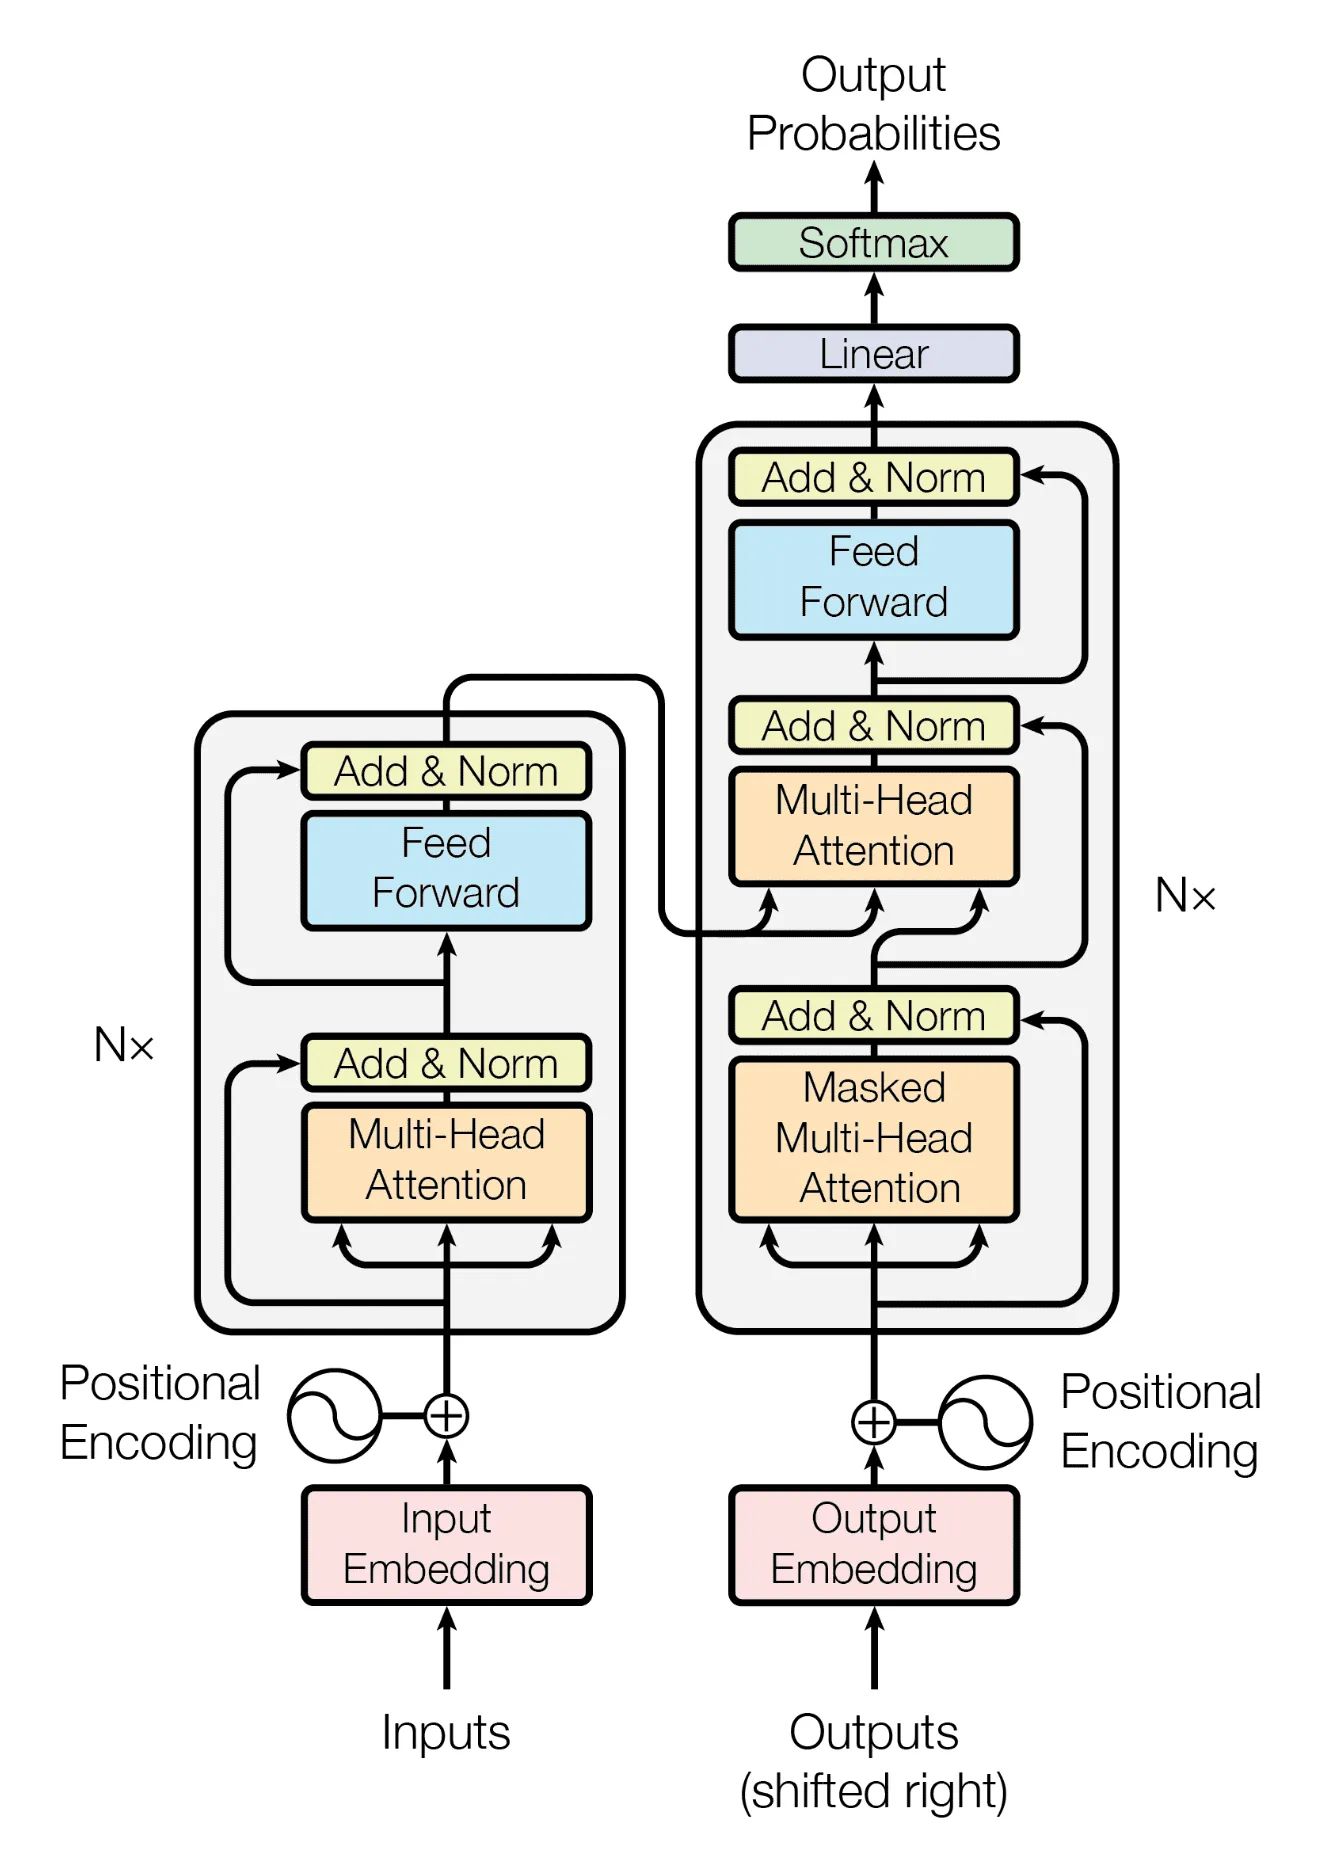

In [2]:
# !pip3 install torch torchvision torchaudio

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

###  Multi-head Attention
The Multi-Head Attention mechanism computes the attention between each pair of positions in a sequence. It consists of multiple “attention heads” that capture different aspects of the input sequence.

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

### Position-wise Feed-Forward Networks
- The PositionWiseFeedForward class defines a position-wise feed-forward neural network that consists of two linear layers with a ReLU activation function in between. 
- In the context of transformer models, this feed-forward network is applied to each position separately and identically. It helps in transforming the features learned by the attention mechanisms within the transformer, acting as an additional processing step for the attention outputs.

In [9]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

### Positional Encoding
Positional Encoding is used to inject the position information of each token in the input sequence. It uses sine and cosine functions of different frequencies to generate the positional encoding.

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

## Encoder Blocks
- The EncoderLayer class defines a single layer of the transformer's encoder. 
- It encapsulates a multi-head self-attention mechanism followed by position-wise feed-forward neural network, with residual connections, layer normalization, and dropout applied as appropriate. 
- These components together allow the encoder to capture complex relationships in the input data and transform them into a useful representation for downstream tasks. 
- Typically, multiple such encoder layers are stacked to form the complete encoder part of a transformer model.

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


## Decoder Blocks
- The DecoderLayer class defines a single layer of the transformer's decoder.
- It consists of a multi-head self-attention mechanism, a multi-head cross-attention mechanism (that attends to the encoder's output), a position-wise feed-forward neural network, and the corresponding residual connections, layer normalization, and dropout layers. 
- This combination enables the decoder to generate meaningful outputs based on the encoder's representations, taking into account both the target sequence and the source sequence. As with the encoder, multiple decoder layers are typically stacked to form the complete decoder part of a transformer model.

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

## Combining the Encoder and Decoder layers to create the complete Transformer network
- The Transformer class brings together the various components of a Transformer model, including the embeddings, positional encoding, encoder layers, and decoder layers.
- It provides a convenient interface for training and inference, encapsulating the complexities of multi-head attention, feed-forward networks, and layer normalization.

- This implementation follows the standard Transformer architecture, making it suitable for sequence-to-sequence tasks like machine translation, text summarization, etc. 
- The inclusion of masking ensures that the model adheres to the causal dependencies within sequences, ignoring padding tokens and preventing information leakage from future tokens.

- These sequential steps empower the Transformer model to efficiently process input sequences and produce corresponding output sequences.



In [13]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

## Training


In [14]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

In [16]:
print(src_data)
print(tgt_data)

tensor([[3597, 3480, 3032,  ...,  211, 4822, 1548],
        [2715, 1882, 2667,  ..., 3797, 3859,   52],
        [3484, 2873, 4629,  ..., 4886, 1693,  310],
        ...,
        [1642, 4268, 3379,  ...,  463, 4748, 2431],
        [ 314, 2254, 1105,  ...,  790, 4516, 2618],
        [ 204, 3224, 2332,  ..., 4919, 2220, 3719]])
tensor([[3309,  851, 4285,  ..., 3319,  780,  427],
        [ 727, 1958, 4958,  ...,  719, 4014, 2998],
        [3661, 1672,  732,  ..., 4094, 2416, 3609],
        ...,
        [1322,  715, 1590,  ..., 3341, 1164, 1125],
        [4400, 4666, 3712,  ..., 4855, 4176, 2755],
        [3112,    8, 1254,  ...,  541,   66, 3320]])


In [17]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")


Epoch: 1, Loss: 8.673942565917969
Epoch: 2, Loss: 8.549418449401855
Epoch: 3, Loss: 8.481612205505371
Epoch: 4, Loss: 8.4237060546875
Epoch: 5, Loss: 8.360235214233398
Epoch: 6, Loss: 8.291801452636719
Epoch: 7, Loss: 8.214105606079102
Epoch: 8, Loss: 8.125396728515625
Epoch: 9, Loss: 8.050263404846191
Epoch: 10, Loss: 7.961400985717773
Epoch: 11, Loss: 7.881472587585449
Epoch: 12, Loss: 7.7964982986450195
Epoch: 13, Loss: 7.715969085693359
Epoch: 14, Loss: 7.627668857574463
Epoch: 15, Loss: 7.545618534088135
Epoch: 16, Loss: 7.461549282073975
Epoch: 17, Loss: 7.380899429321289
Epoch: 18, Loss: 7.302557945251465
Epoch: 19, Loss: 7.214003562927246
Epoch: 20, Loss: 7.141483306884766
Epoch: 21, Loss: 7.05165958404541
Epoch: 22, Loss: 6.9781928062438965
Epoch: 23, Loss: 6.898730278015137
Epoch: 24, Loss: 6.82535982131958
Epoch: 25, Loss: 6.747025489807129
Epoch: 26, Loss: 6.67003059387207
Epoch: 27, Loss: 6.609377861022949
Epoch: 28, Loss: 6.530807971954346
Epoch: 29, Loss: 6.4586620330810

In [18]:
transformer.eval()

# Generate random sample validation data
val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

with torch.no_grad():

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 8.832250595092773


References: 
- https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch
